In [84]:
import pandas as pd
import requests 
from urllib.parse import urlencode
import numpy as np
import seaborn as sns
import matplotlib
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import pandahouse as ph

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [85]:
# Выгружаем данные напрямую с диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_1 = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
public_key_2 = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
public_key_3 = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
public_key_4 = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'
final_url_1 = base_url + urlencode(dict(public_key=public_key_1)) 
final_url_2 = base_url + urlencode(dict(public_key=public_key_2))
final_url_3 = base_url + urlencode(dict(public_key=public_key_3))
final_url_4 = base_url + urlencode(dict(public_key=public_key_4))
response_1 = requests.get(final_url_1)
response_2 = requests.get(final_url_2)
response_3 = requests.get(final_url_3)
response_4 = requests.get(final_url_4)
download_url_1 = response_1.json()['href'] 
download_url_2 = response_2.json()['href'] 
download_url_3 = response_3.json()['href']
download_url_4 = response_4.json()['href'] 
groups =       pd.read_csv(download_url_1, sep=';')
group_add =   pd.read_csv(download_url_2, sep=',')
active_studs = pd.read_csv(download_url_3, sep=';')
checks =       pd.read_csv(download_url_4, sep=';')

In [86]:
all_group=pd.concat([groups, group_add], ignore_index=True)
all_group.head(7)

# делаем единый ДФ для всех студентов (объединила groups и group_add)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
5,1803,B
6,1805,B


In [87]:
all_group.shape

(74576, 2)

In [88]:
all_group.isna().sum()
#проверяю, что в groups и group_add не было пустых значений

id     0
grp    0
dtype: int64

In [89]:
all_group.nunique()

#проверяю, что в groups и group_add не было случайного повтора 

id     74576
grp        2
dtype: int64

In [90]:
all_group.dtypes

#проверяю тип данных

id      int64
grp    object
dtype: object

In [91]:
active_studs.shape

# обращаем внимание, что в active_studs записано намного меньше пользователей, чем в all_group
# так как нам интересно влияние новой механики оплаты услуг, то есть смысл далее рассматривать только тех пользователей, 
# которые зашли на платформу в дни проведения эксперимента

(8341, 1)

In [92]:
active_studs=active_studs.rename(columns={'student_id':'id'})
active_studs.head()
# переименовала колонку, чтобы потом сделать merge по ней

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [93]:
active_all_group = pd.merge(all_group, active_studs, how="right", on=["id"])
active_all_group.shape

# оставила из all_group только тех пользователей,которые зашли на платформу в дни проведения эксперимента
# сразу проверила, что все ок и данные не потеряла. Размерность совпадает

(8341, 2)

In [94]:
checks.shape

# по условию задачи не сказано, на что конкретно исследуется влияние нового механизма оплаты. 
# Так как в наличии мы имеем только данные об оплатах, то это и будет нашей зависимой величиной.
# При этом обращаем внимание, что в checks данных < чем в active_all_group, а это говорит о том, что
# среди пользователей, зашедших на платформу в дни эксперимента, большая часть не совершала оплаты. 
# для дальнейшего исследования нам необходимо объединить active_all_group и checks по id из active_all_group. 
# При этом для всех id из checks, которые не совершали оплаты значение rev сделаем = 0

(541, 2)

In [95]:
checks=checks.rename(columns={'student_id':'id'})
checks.head(10)

# переименовала колонку, чтобы потом сделать merge по ней

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
5,100645,630.0
6,102534,580.0
7,106837,290.0
8,108270,290.0
9,114366,690.0


In [96]:
common_info = pd.merge(active_all_group, checks, how="left", on=["id"])
common_info=common_info.fillna(0)
common_info.head()

# Получаем итоговый ДФ со всей интересующей нас информацией

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [97]:
common_info['Fact'] = np.where(common_info['rev']>0, '1', '0')
common_info['Fact']=common_info['Fact'].astype (str).astype (int)
common_info.head()

# рассмотрим как вообще могло измениться количество оплат для групп А и В

,id,grp,rev,Fact
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0


In [98]:
pd.crosstab(common_info.grp, common_info.Fact)

#сразу можно увидеть, что в принципе группа А намного меньше группы В
# из группы А 78 пользователей совершили оплату, 1460 - не совершили
# из группы В 314 пользователей совершили оплату, 6489 - не совершили

Fact,0,1
grp,,
A,1460,78
B,6489,314


In [99]:
# по предварительным наблюдениям, можно сказать что % пользователей, которые совершают покупки изменился не очень сильно
# можно ли считать это различие стат значимым?

# выдвигаем H0: новый механизм оплаты не оказывает эффекта на конверсию (CR - основная метрика проверки)
# принимаем уровень достоверности = 95%,  альфа=0,05.

# также можем выдвинуть Н0: новый механизм оплаты не оказывает эффект на среднее rev

In [100]:
alpha=0.05

In [101]:
A_group=common_info.query('grp=="A"')
A_group['Fact']=A_group['Fact'].astype (str).astype (int)
A_group.head()

# перевела значения колонки Fact в int

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,grp,rev,Fact
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0


In [102]:
B_group=common_info.query('grp=="B"')
B_group['Fact']=B_group['Fact'].astype (str).astype (int)
B_group.head()

# перевела значения колонки Fact в int

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,grp,rev,Fact
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0


In [103]:
CR=common_info.groupby('grp', as_index=False)\
   .agg({'Fact':'mean'})\
   .rename(columns={'Fact':'CR'})
CR

# посмотрим CR по группам

,grp,CR
0,A,0.050715
1,B,0.046156


In [104]:
ARPU=common_info.groupby('grp', as_index=False)\
    .agg({'rev':'mean'})\
    .rename(columns={'rev':'ARPU'})
ARPU

# посмотрим среднее по оплатам по группам

,grp,ARPU
0,A,47.347204
1,B,58.058798


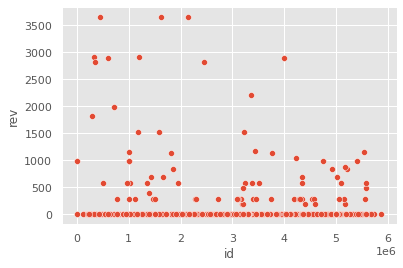

In [105]:
sns.scatterplot(data=A_group, x="id", y="rev")

# По графику видно, что большинство студентов не совершили оплату (в принципе это было видно и из crosstab)

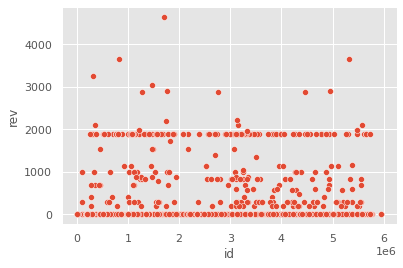

In [106]:
sns.scatterplot(data=B_group, x="id", y="rev")

# По графику видно, что большинство студентов либо не совершили оплату, либо заплатили одинаково (примерно 2000). 
# Интересна причина скопления точек на уровне rev=2000. Появляются сомнения по поводу репрезентвативности выборки
# Также учтем, что это "скопление" повлияет на результаты сравнение групп по параметру rev 

In [109]:
rev_id=B_group.groupby('rev', as_index=False).agg({'id':'count'}).sort_values('id', ascending=False)
rev_id

# решила посмотреть поподробнее на значения в scatterplot

,rev,id
0,0.0000,6489
21,1900.0000,93
2,290.0000,45
22,1900.0001,35
1,199.0000,27
10,840.0000,21
13,990.0000,17
8,690.0000,13
15,1140.0000,9
6,590.0000,6


In [110]:
x = common_info['rev'][(common_info['grp']=="A")]
y = common_info['rev'][(common_info['grp']=="B")]
a = common_info['Fact'][(common_info['grp']=="A")]
b = common_info['Fact'][(common_info['grp']=="B")]

# поместим нужные нам данные в новые переменные

In [111]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

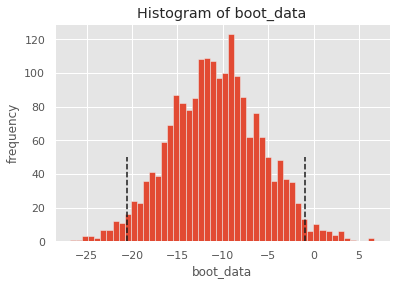

In [112]:
booted_data_rev = get_bootstrap(x, y, boot_it = 2000) 

# среднее по значениям Rev
# в результате хранится разница двух распределений, ДИ и pvalue

In [113]:
p_value=booted_data_rev["p_value"]
print('Н0: новый механизм оплаты не оказывает эффекта на среднее rev')

if p_value < alpha:
    print('p_value = {}. Отклоняем Н0'.format(p_value))
else:
    print('p_value =  {}. Нет оснований отклонять Н0'.format(p_value))


Н0: новый механизм оплаты не оказывает эффекта на среднее rev
p_value = 0.03306951228796822. Отклоняем Н0


In [114]:
booted_data_rev["ci"]

,0
0.025,-20.596032
0.975,-0.985492


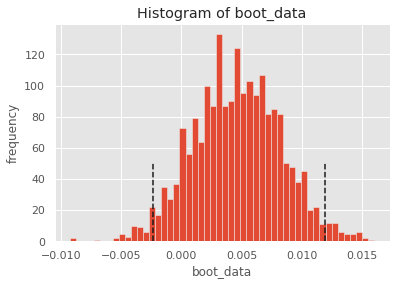

In [115]:
booted_data_CR = get_bootstrap(a, b, boot_it = 2000) 


# среднее по значениям Fact
# в результате хранится разница двух распределений, ДИ и pvalue

In [116]:
p_value=booted_data_CR["p_value"]
print('Н0: новый механизм оплаты не оказывает эффекта на CR')

if p_value < alpha:
    print('p_value = {}. Отклоняем Н0'.format(p_value))
else:
    print('p_value =  {}. Нет оснований отклонять Н0'.format(p_value))


Н0: новый механизм оплаты не оказывает эффекта на CR
p_value =  0.2053505143414791. Нет оснований отклонять Н0


In [117]:
booted_data_CR["ci"]

,0
0.025,-0.002356
0.975,0.011907


In [118]:
# Таким образом, после применения bootstrap 
# Н0: новый механизм оплаты не оказывает эффекта на CR - Нет оснований отклонять
# Н0: новый механизм оплаты не оказывает эффекта на среднее rev - отклоняется
# Можно было бы предположить, что новый механизм оплаты оказывает эффект на среднее rev. 
# Но если рассуждать логически: как может механизм оплаты повлиять на среднюю величину оплаты пользователей?

# 1) Судя по scatterplot для группы В новый механизм мог дать сбой и у пользователей отобразилась оплата 
# в размере 1900 и 1900.0001, что естетственно повлияло на результаты исследования. В данном случае выкатывать обновление не стоит.
# 2) По условию не раскрыта суть "нового механизма оплаты". Здесь остается только фантазировать. 
# Возможно новый механизм предусматривал какое-нибудь акционное предложение (как раз на сумму 1900) и в таком случае, 
# среднее rev объективно увеличивается и стоит выкатывать обновление.
# 3) Возможно существует еще один фактор (который мы не знаем), который мог оказать эффект на среднее rev. 
# Но в таком случае изменение величины среднего rev не зависит от нового механизма оплаты.

# Подводем итог вышеизложенного. Мы не можем утверждать, что новый механизм оплаты оказывает эффект на CR пользователей. 
# Также исходя из здравого смысла и отсутствия уточняющих данных принимается решение, что новый механизм оплаты так же
# не оказывает нужного положительного эффекта и на среднее rev. 
# В связи с этим принимается решение НЕ выкатывать обновление.

In [119]:
# Задание 2. SQL
# 2.1 Очень усердные ученики.

In [120]:
# создаем подключение к clickhouse
connection =  {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     } 

In [121]:
query = '''
SELECT st_id, toDateTime(timest) as timest, correct, subject
FROM peas
'''
df_peas = ph.read_clickhouse(query=query, connection=connection)
df_peas.head()

#смотрим, что за данные в таблице peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [122]:
query = '''
SELECT
    MIN(toDateTime(timest)) AS MIN,
    MAX(toDateTime(timest)) AS MAX
FROM peas

'''
df_time = ph.read_clickhouse(query=query, connection=connection)
df_time

# смотрим за какой промежуток времени данные

,MIN,MAX
0,2021-10-30 13:00:00,2021-10-31 17:29:52


In [123]:
# "Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин."

# То есть по идеи нам даже не надо группировать по месяцам, потому что все данные представлены за 2 дня…
# однако возникает вопрос. Усердный - это когда всего (в сумме по всем предметам) решил правильно 20 горошин?
# Или же усердный - это когда есть хотя бы один предмет, в котором решил правильно 20 горошин?
# так как по условию не очень понятно, то дадим ответ на оба вопроса.

In [124]:
query = '''
SELECT 
    COUNT (DISTINCT st_id) AS num_of_st
FROM (
    SELECT
        st_id,
        SUM (correct) AS common_corr
    FROM default.peas
    GROUP BY st_id)
WHERE common_corr >=20


'''

df_peas_1 = ph.read_clickhouse(query=query, connection=connection)
df_peas_1

# Ответ: 136 студентов решили более 20 горошин за месяц. (не важно: за один предмет или в сумме за разные)

,num_of_st
0,136


In [125]:
query = '''
SELECT 
    COUNT (DISTINCT st_id) AS num_of_st
FROM (
    SELECT
      st_id,
      subject,
      SUM(correct) AS common_corr
    FROM default.peas
    GROUP BY (subject, st_id)) 
WHERE common_corr>=20

'''
df_peas_2 = ph.read_clickhouse(query=query, connection=connection)
df_peas_2

# Ответ: 78 студентов решили более 20 горошин за месяц. (т.е. 20 и больше за один предмет)

,num_of_st
0,78


In [126]:
# 2.2 Оптимизация воронки

In [127]:
query = '''
SELECT *
FROM studs
'''
df_studs = ph.read_clickhouse(query=query, connection=connection)
df_studs.head()

#смотрим, что за данные в таблице studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [128]:
query = '''
SELECT 
    st_id,
    toDateTime(sale_time) as sale_time,
    money,
    subject as new_subject
FROM final_project_check


'''
df_fpc = ph.read_clickhouse(query=query, connection=connection)
df_fpc.head()

# смотрим, что за данные в таблице final_project_check
# обращаем внимание, что в разных таблицах есть колонки "subject", которые несут разный смысл. Поэтому переименуем тут колонку

,st_id,sale_time,money,new_subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math


In [129]:
query = '''

SELECT
test_grp,
SUM_money/uniq_student AS ARPU,
SUM_money/act_student AS ARPAU,
(pay_student/uniq_student*100) AS CR,
(act_pay_student/act_student*100) AS CR_act_student,
(act_math_pay_student/act_math_student*100) AS CR_math


FROM

(SELECT act_student, test_grp, act_pay_student, pay_student, SUM_money, uniq_student, act_math_student, act_math_pay_student
FROM
(SELECT act_student, test_grp, act_pay_student, pay_student, SUM_money, uniq_student, act_math_student
FROM
(SELECT act_student, test_grp, act_pay_student, pay_student, SUM_money, uniq_student
FROM
(SELECT act_student, test_grp, act_pay_student, pay_student
FROM
(SELECT act_student, Z.test_grp, act_pay_student
FROM 
(SELECT 
COUNT (DISTINCT st_id) AS act_student,
test_grp
FROM
(SELECT 
    coalesce ((CASE WHEN empty(st_id) THEN null ELSE st_id END), D.st_id) AS st_id, 
    coalesce ((CASE WHEN empty(subject) THEN null ELSE subject END), D.subject) AS demo_subject,
    common_corr,
    coalesce (D.money,0) AS money,
    D.subject as new_subject,
    test_grp
FROM
    (SELECT B.st_id as st_id, common_corr, subject, test_grp
    FROM    
        (SELECT
            st_id,
            SUM(correct) AS common_corr,
            subject
        FROM default.peas
        GROUP BY (st_id, subject)) AS A
        FULL JOIN default.studs AS B
        ON A.st_id=B.st_id) AS C
    LEFT JOIN default.final_project_check AS D
    ON C.st_id=D.st_id
    WHERE common_corr>10)
    GROUP BY test_grp) AS Z
    
FULL JOIN 

(
SELECT 
COUNT (DISTINCT st_id) AS act_pay_student,
test_grp
FROM
(SELECT 
    coalesce ((CASE WHEN empty(st_id) THEN null ELSE st_id END), D.st_id) AS st_id, 
    coalesce ((CASE WHEN empty(subject) THEN null ELSE subject END), D.subject) AS demo_subject,
    common_corr,
    coalesce (D.money,0) AS money,
    D.subject as new_subject,
    test_grp
FROM
    (SELECT B.st_id as st_id, common_corr, subject, test_grp
    FROM    
        (SELECT
            st_id,
            SUM(correct) AS common_corr,
            subject
        FROM default.peas
        GROUP BY (st_id, subject)) AS A
        FULL JOIN default.studs AS B
        ON A.st_id=B.st_id) AS C
    LEFT JOIN default.final_project_check AS D
    ON C.st_id=D.st_id
    WHERE common_corr>10 and money>0)
    GROUP BY test_grp
) AS Y
ON Z.test_grp=Y.test_grp) AS X

FULL JOIN

(
SELECT 
COUNT (DISTINCT st_id) AS pay_student,
test_grp
FROM
(SELECT 
    coalesce ((CASE WHEN empty(st_id) THEN null ELSE st_id END), D.st_id) AS st_id, 
    coalesce ((CASE WHEN empty(subject) THEN null ELSE subject END), D.subject) AS demo_subject,
    common_corr,
    coalesce (D.money,0) AS money,
    D.subject as new_subject,
    test_grp
FROM
    (SELECT B.st_id as st_id, common_corr, subject, test_grp
    FROM    
        (SELECT
            st_id,
            SUM(correct) AS common_corr,
            subject
        FROM default.peas
        GROUP BY (st_id, subject)) AS A
        FULL JOIN default.studs AS B
        ON A.st_id=B.st_id) AS C
    LEFT JOIN default.final_project_check AS D
    ON C.st_id=D.st_id
    WHERE money>0)
    GROUP BY test_grp
) AS W
ON X.test_grp=W.test_grp) AS V

FULL JOIN

(SELECT 
SUM(money) AS SUM_money,
COUNT(DISTINCT st_id) AS uniq_student,
test_grp
FROM
(SELECT 
    r.st_id AS st_id,
    l.sale_time,
    l.money,
    l.subject,
    r.test_grp
FROM 
    default.final_project_check AS l 
    RIGHT JOIN default.studs AS r
    ON l.st_id=r.st_id)
GROUP BY test_grp) AS U
ON V.test_grp=U.test_grp) AS T

FULL JOIN

(SELECT COUNT (DISTINCT st_id) AS act_math_student,
test_grp
FROM
(SELECT 
    coalesce ((CASE WHEN empty(st_id) THEN null ELSE st_id END), D.st_id) AS st_id, 
    coalesce ((CASE WHEN empty(subject) THEN null ELSE subject END), D.subject) AS demo_subject,
    common_corr,
    coalesce (D.money,0) AS money,
    D.subject as new_subject,
    test_grp
FROM
    (SELECT B.st_id as st_id, common_corr, subject, test_grp
    FROM    
        (SELECT
            st_id,
            SUM(correct) AS common_corr,
            subject
        FROM default.peas
        GROUP BY (st_id, subject)) AS A
        FULL JOIN default.studs AS B
        ON A.st_id=B.st_id) AS C
    LEFT JOIN default.final_project_check AS D
    ON C.st_id=D.st_id
    WHERE common_corr>=2 and demo_subject='Math')
    GROUP BY test_grp
) AS S
ON S.test_grp=T.test_grp) AS R

FULL JOIN

(SELECT COUNT (DISTINCT st_id) AS act_math_pay_student,
test_grp
FROM
(SELECT 
    coalesce ((CASE WHEN empty(st_id) THEN null ELSE st_id END), D.st_id) AS st_id, 
    coalesce ((CASE WHEN empty(subject) THEN null ELSE subject END), D.subject) AS demo_subject,
    common_corr,
    coalesce (D.money,0) AS money,
    D.subject as new_subject,
    test_grp
FROM
    (SELECT B.st_id as st_id, common_corr, subject, test_grp
    FROM    
        (SELECT
            st_id,
            SUM(correct) AS common_corr,
            subject
        FROM default.peas
        GROUP BY (st_id, subject)) AS A
        FULL JOIN default.studs AS B
        ON A.st_id=B.st_id) AS C
    LEFT JOIN default.final_project_check AS D
    ON C.st_id=D.st_id
    WHERE common_corr>=2 and demo_subject='Math' and new_subject='Math' )
    GROUP BY test_grp
) AS Q
ON R.test_grp=Q.test_grp)


    '''
dfdf = ph.read_clickhouse(query=query, connection=connection)
dfdf

#наверняка это можно было сделать в гораздо меньшее кол-во строк кода. Но то ли опыта, то ли мозгов не хватило. 

,test_grp,ARPU,ARPAU,CR,CR_act_student,CR_math
0,control,4540.983607,11737.288136,4.918033,11.016949,6.122449
1,pilot,11508.474576,37307.692308,10.847458,25.274725,9.523810


In [130]:
# Задание 3. Python
# 3.1 Задача

# 1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv 
# (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.


# и в этот момент приходит осознание, что походу не надо было делать объединение groups.csv и groups_add.csv в самом начале...
# Это что же получается? я все неправильно сделала?(

In [131]:
def concat_group_add(file_url):
    
    def link(key): #функция для получения ссылок
        base = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        url = base + urlencode(dict(public_key=key))
        response = requests.get(url)
        return response.json()['href']

    group_add = pd.read_csv(link( file_url ))
    groups = pd.read_csv(link( 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'), sep=';')
    active_studs = pd.read_csv(link( 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'), sep=';') 
    checks = pd.read_csv(link( 'https://disk.yandex.ru/d/84hTmELphW2sqQ'), sep=';') 
    
    all_group=pd.concat([groups, group_add], ignore_index=True) # объединяем groups и group_add (аналогично заданию №1)

    checks=checks.rename(columns={'student_id':'id'}) # переименовали student_id в id, чтобы избежать проблем с merge 
    active_studs=active_studs.rename(columns={'student_id':'id'})                          #(аналогично заданию №1)
    
    active_all_group = pd.merge(all_group, active_studs, how="right", on=["id"]) # применяем merge для всех ДФ, 
    common_info = pd.merge(active_all_group, checks, how="left", on=["id"]).fillna(0)
    common_info['Fact'] = np.where(common_info['rev']>0, '1', '0') # создаю колонку Fact, чтобы отобразить 1 - если была оплата, 0 - если нет
    common_info['Fact']=common_info['Fact'].astype (str).astype (int)
 
    
    # Найдем CR и  ARPU с разбивкой по группам (аналогично заданию №1)
    metric = common_info\
        .groupby('grp', as_index=False)\
        .agg({'Fact':'mean', 'rev' : 'mean'})\
        .rename(columns={'Fact': 'CR', 'rev' : 'ARPU'})

    # Переведем CR в проценты.
    metric['CR'] = metric['CR'] * 100
    
    return metric

In [132]:
itog = concat_group_add('https://disk.yandex.ru/d/3aARY-P9pfaksg')
itog

,grp,CR,ARPU
0,A,5.071521,47.347204
1,B,4.615611,58.058798


In [133]:
# 2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [134]:
def graphic(itog):
    
    # Задание настроек графика
    sns.set(font_scale = 1, style="darkgrid")
    fig, axes = plt.subplots(2, figsize=(6, 10))
    
    # Рисуем график
    sns.barplot(ax=axes[0], data=itog, x='grp', y='ARPU')
    sns.barplot(ax=axes[1], data=itog, x='grp', y='CR')
    

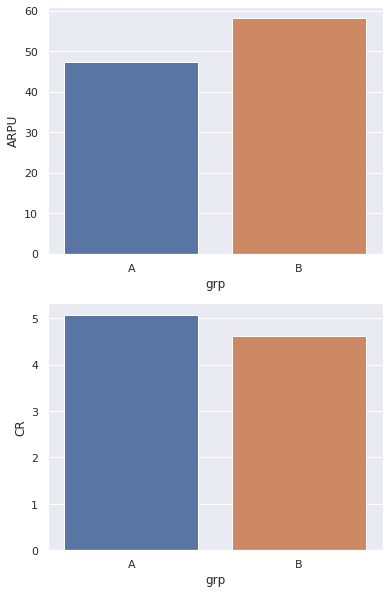

In [135]:
graphic(itog)

In [136]:
# Остается нерешенным вопрос - надо ли было использовать group_add в 1 задании всего проекта? 
# для себя отвечу, что надо было. Иначе логичнее было бы вперые упомянуть эти данные в 3 задании, а не в 1.
# Да и в принципе функция из 3 задания позволяет подгружать дополнительные данные. Кто знает сколько еще этих group_add будет...